Camembert pour les descriptions

- On entraine QUE sur les lignes qui ont des desc
- On sauve le modele
- On Evalue le modele
- On recharge le modele, génère les embeddings et les sauve dans un CSV

In [ ]:
# EXECUTER CETTE CELL ---OU--- La suivante, mais pas les deux

#premiere stratégie: on prend le début de phrase, puis on prend les n mots les plus fréquents dans le reste

import nltk
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')

languages = ['danish', 'dutch', 'english', 'finnish', 
    'french', 'german', 'italian','norwegian', 'portuguese', 'spanish', 'swedish' ]

all_stopwords = set()
for lang in languages:
    all_stopwords.update(stopwords.words(lang))
        
# fonction qui crop à X mots puis ajoute les mots les plus fréquents dans le reste.
def crop_sentence(sentence, X, Y, languages=[]):  
    
    words = sentence.split()
    
    # Si le nombre de mots est inférieur ou égal à X, renvoie la phrase telle quelle.
    if len(words) <= X:
        return sentence
    
    # Prendre les X-Y premiers mots.
    main_words = words[:X-Y]
    
    # Obtenir la fréquence des mots restants, sans tenir compte des stopwords
    remaining_words = [word for word in words[X-Y:] if word.lower() not in all_stopwords]
    word_freq = Counter(remaining_words)
    
    # Prendre les Y mots les plus courants.
    common_words = [item[0] for item in word_freq.most_common(Y)]
    
    # Combiner les deux listes et renvoyer le résultat.
    return ' '.join(main_words + common_words)

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm

class TextSummarizer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("moussaKam/barthez-orangesum-abstract")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("moussaKam/barthez-orangesum-abstract")

    def summarize(self, text, max_words,max_len):
        # Compte le nombre de mots dans le texte
        num_words = len(text.split())

        # Si le texte a plus que max_words, alors on resume le texte
        if num_words > max_words:
            inputs = self.tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
            outputs = self.model.generate(inputs, max_length=max_len, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
            txt = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return txt
        else:
            return text

# Test
summarizer = TextSummarizer()

from RktnChallenge.RktnModel import ModelTrainer
trainer = ModelTrainer("data_tr_lemm.csv","")
trainer.data['tr_description'] = trainer.data['tr_description'].fillna(" ")

tqdm.pandas(desc="Summarizing texts")
trainer.data['tr_description_sum'] = trainer.data['tr_description'].progress_apply(lambda desc: summarizer.summarize(desc, 200,200))
trainer.data.to_csv("data_tr_lemm.csv")

2023-09-18 22:52:41.355997: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 22:52:41.958944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-18 22:52:41.958968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-18 22:52:41.964013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-18 22:52:42.263992: I tensorflow/core/platform/cpu_feature_guar

In [5]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 20
num_categories = 27
max_features = 300
checkpoint_path = "cbert_best_desc_sum"

#malheureusement les arrays sont convertis
#en chaine de caractères, on doit re-caster
def convert_and_join(str_list):
    try:        
        real_list = ast.literal_eval(str_list)        
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""


trainer.data['tr_description_sum'] = trainer.data['tr_description_sum'].fillna("")

labels = y = trainer.encodeLabel("prdtypecode")
#sentences =  trainer.data["tr_description_tkn"].apply(convert_and_join).values.tolist()
sentences =  trainer.data["tr_description_sum"].values.tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

valid_indices = [i for i, x in enumerate(sentences_train) if x != ""]
sentences_train = [sentences_train[i] for i in valid_indices]
labels_train = [labels_train[i] for i in valid_indices]

sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_train, labels_train, test_size=0.1, random_state=42)


from transformers import CamembertConfig, TFCamembertModel
modelpoint = 'jplu/tf-camembert-base'
config = CamembertConfig.from_pretrained(modelpoint)
config.num_labels = 27

tokenizer = CamembertTokenizer.from_pretrained(modelpoint)
model = TFCamembertForSequenceClassification.from_pretrained(modelpoint, config=config)



def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)
X_val = encode_sentences(sentences_val, tokenizer)

y_train = np.array(labels_train)
y_test = np.array(labels_test)
y_val = np.array(labels_val)

from transformers import AdamWeightDecay

print("compile model...")
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=3, 
            verbose=1, restore_best_weights=True
        ) 

print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)




2023-09-19 05:59:04.059920: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-19 05:59:04.060764: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-19 05:59:04.061403: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-19 05:59:04.062131: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-19 05:59:04.062141: I tensorflow/core/common

encoding sentences...
compile model...
fit...
Epoch 1/20


2023-09-19 05:59:27.311125: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-19 05:59:48.472406: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb7bc3faca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-19 05:59:48.472449: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-19 05:59:48.518353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-19 05:59:48.839594: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-19 05:59:48.920900: I ./tensor

7643/7643 [==============================] - ETA: 0s - loss: 1.8831 - accuracy: 0.4808

2023-09-19 06:52:34.702597: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



7643/7643 [==============================] - 3317s 430ms/step - loss: 1.8831 - accuracy: 0.4808 - val_loss: 1.5000 - val_accuracy: 0.5574
Epoch 2/20
7643/7643 [==============================] - 3267s 427ms/step - loss: 1.3990 - accuracy: 0.5798 - val_loss: 1.4146 - val_accuracy: 0.5752
Epoch 3/20
7643/7643 [==============================] - 3391s 444ms/step - loss: 1.2849 - accuracy: 0.6071 - val_loss: 1.3781 - val_accuracy: 0.5895
Epoch 4/20
7643/7643 [==============================] - 8544s 1s/step - loss: 1.2165 - accuracy: 0.6277 - val_loss: 1.3754 - val_accuracy: 0.5921
Epoch 5/20
7643/7643 [==============================] - 3299s 432ms/step - loss: 1.1652 - accuracy: 0.6392 - val_loss: 1.3774 - val_accuracy: 0.5966
Epoch 6/20
7643/7643 [==============================] - 3284s 430ms/step - loss: 1.1274 - accuracy: 0.6504 - val_loss: 1.4006 - val_accuracy: 0.5983
Epoch 7/20
7643/7643 [==============================] - 3314s 434ms/step - loss: 1.1001 - accuracy: 0.6586 - val_loss: 1

('cbert_best_desc_sum/tokenizer_config.json',
 'cbert_best_desc_sum/special_tokens_map.json',
 'cbert_best_desc_sum/sentencepiece.bpe.model',
 'cbert_best_desc_sum/added_tokens.json')

In [ ]:

labels = y = trainer.encodeLabel("prdtypecode")
#sentences =  trainer.data["tr_description_tkn"].apply(convert_and_join).values.tolist()
sentences =  trainer.data["tr_description_sum"].values.tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

valid_indices = [i for i, x in enumerate(sentences_train) if x != ""]
sentences_train = [sentences_train[i] for i in valid_indices]
labels_train = [labels_train[i] for i in valid_indices]

sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_train, labels_train, test_size=0.1, random_state=42)


from transformers import CamembertConfig, TFCamembertModel
modelpoint = 'jplu/tf-camembert-base'
config = CamembertConfig.from_pretrained(modelpoint)
config.num_labels = 27

tokenizer = CamembertTokenizer.from_pretrained(modelpoint)
model = TFCamembertForSequenceClassification.from_pretrained(modelpoint, config=config,training =True)



def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)
X_val = encode_sentences(sentences_val, tokenizer)

y_train = np.array(labels_train)
y_test = np.array(labels_test)
y_val = np.array(labels_val)

from transformers import AdamWeightDecay

print("compile model...")
print("compile model...")
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=3, 
            verbose=1, restore_best_weights=True
        ) 

print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)




In [1]:
trainer.data.info()

NameError: name 'trainer' is not defined

In [6]:
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-09-11 11:21:39.488333: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./cbert_best_desi: FAILED_PRECONDITION: cbert_best_desi; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [5]:

model = TFCamembertForSequenceClassification.from_pretrained(checkpoint_path,training =False)
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at cbert_best_desc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [6]:

y_pred_test = model.predict(X_test)


2023-09-19 17:38:11.806000: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 300s 560ms/step


weighted F1 score: 0.6103518913378136


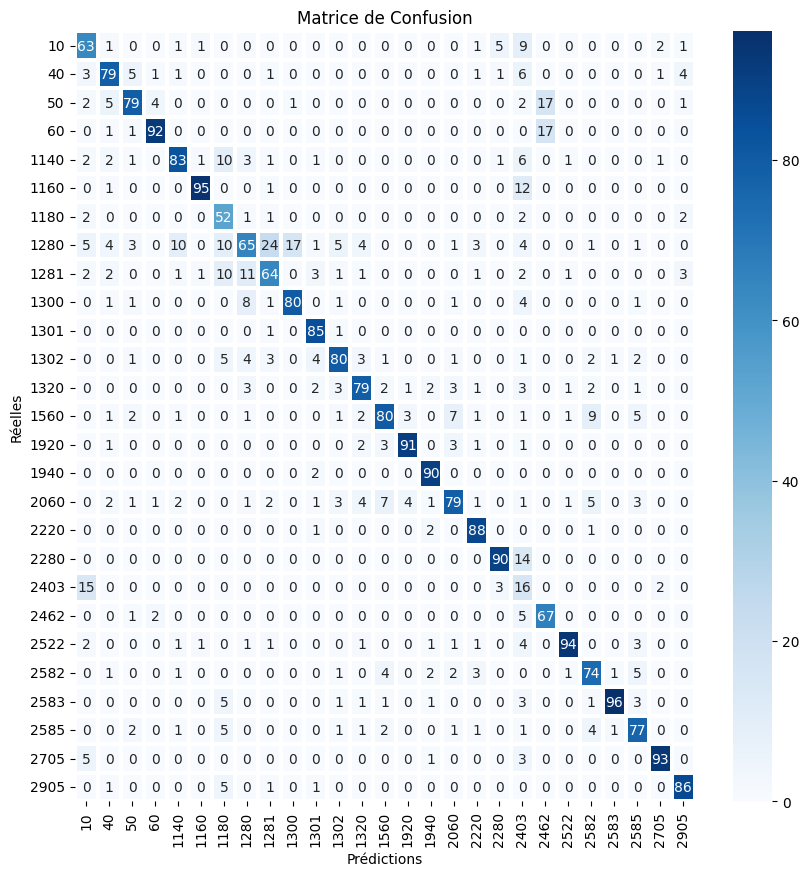

In [7]:
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

weighted F1 score: 0.5411316705216905


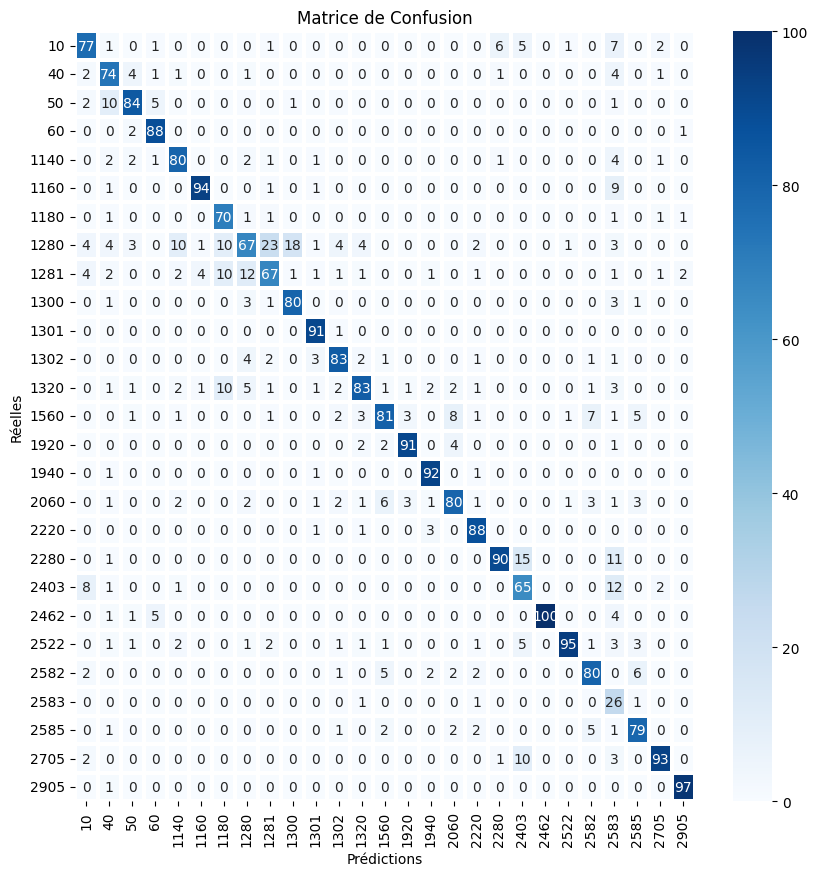

In [3]:
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desc_sum"


def convert_and_join(str_list):
    try:        
        real_list = ast.literal_eval(str_list)
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



#sentences =  trainer.data["description_tkn"].apply(convert_and_join).values.tolist()
sentences =  trainer.data["tr_description_sum"].values.tolist()

from transformers import CamembertConfig, TFCamembertModel

config = CamembertConfig.from_pretrained(checkpoint_path)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)
model = TFCamembertModel.from_pretrained(checkpoint_path, config=config)


for layer in model.layers:
    layer.trainable = False




2023-09-25 07:36:48.646034: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 07:36:48.670108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-25 07:36:48.670129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-25 07:36:48.670143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-25 07:36:48.675231: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tqdm import tqdm

def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True,  max_length=max_features)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

df = pd.read_csv("embeddings.csv")

# embeddings pour chaque texte
df['embeddings_desc'] = [sentence_to_embedding(text) for text in tqdm(sentences)]

df.to_csv("embeddings_final.csv", index=False)


100%|██████████| 84916/84916 [2:46:47<00:00,  8.49it/s]  


In [ ]:
df = pd.read_csv("embeddings.csv")

df2 = pd.read_csv("embeddings_final.csv")

df2['embeddings_desi'] = df2['embeddings_desi']

df2.to_csv("embeddings_final.csv", index=False)